# U-Net for Lightweight Segmentation: Optimizing and Benchmarking Inference Efficiency

This notebook explores optimization techniques for a U-Net model designed for image segmentation. We'll implement:
- **Quantization**: Reducing model precision for efficiency.
- **Pruning**: Removing unnecessary weights to slim down the model.
- **Mixed Precision**: Using lower-precision types to speed up training and inference.

The dataset used is the Oxford-IIIT Pet Dataset, and all experiments run in a Conda environment with Python 3.10.16.

## Setup and Data Preparation

### Dataset
- **Source**: [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
- **Path**: Set `DATASET_PATH` to your local directory containing `images` and `annotations/trimaps`.

Let’s load the libraries and prepare the data.

In [8]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import psutil
from tensorflow.keras import backend as K
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow_model_optimization as tfmot

# Constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 5
DATASET_PATH = "oxford-iiit-pet"  # Update this to your dataset directory
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
MASKS_PATH = os.path.join(DATASET_PATH, "annotations/trimaps")

# Load image and mask file lists
image_files = sorted([os.path.join(IMAGES_PATH, f) for f in os.listdir(IMAGES_PATH) if f.endswith(".jpg")])
mask_files = sorted([os.path.join(MASKS_PATH, f) for f in os.listdir(MASKS_PATH) if f.endswith(".png")])

# Verify matching pairs
assert len(image_files) == len(mask_files), "Mismatch between images and masks!"
print(f"Total images: {len(image_files)}, Total masks: {len(mask_files)}")

Total images: 7390, Total masks: 7390


## Data Loading and Visualization

Here, we define functions to load and preprocess images and masks, plus a quick way to visualize them.

2025-03-11 15:45:40.650587: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-03-11 15:45:40.650632: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-03-11 15:45:40.650644: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-03-11 15:45:40.650706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-11 15:45:40.650745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


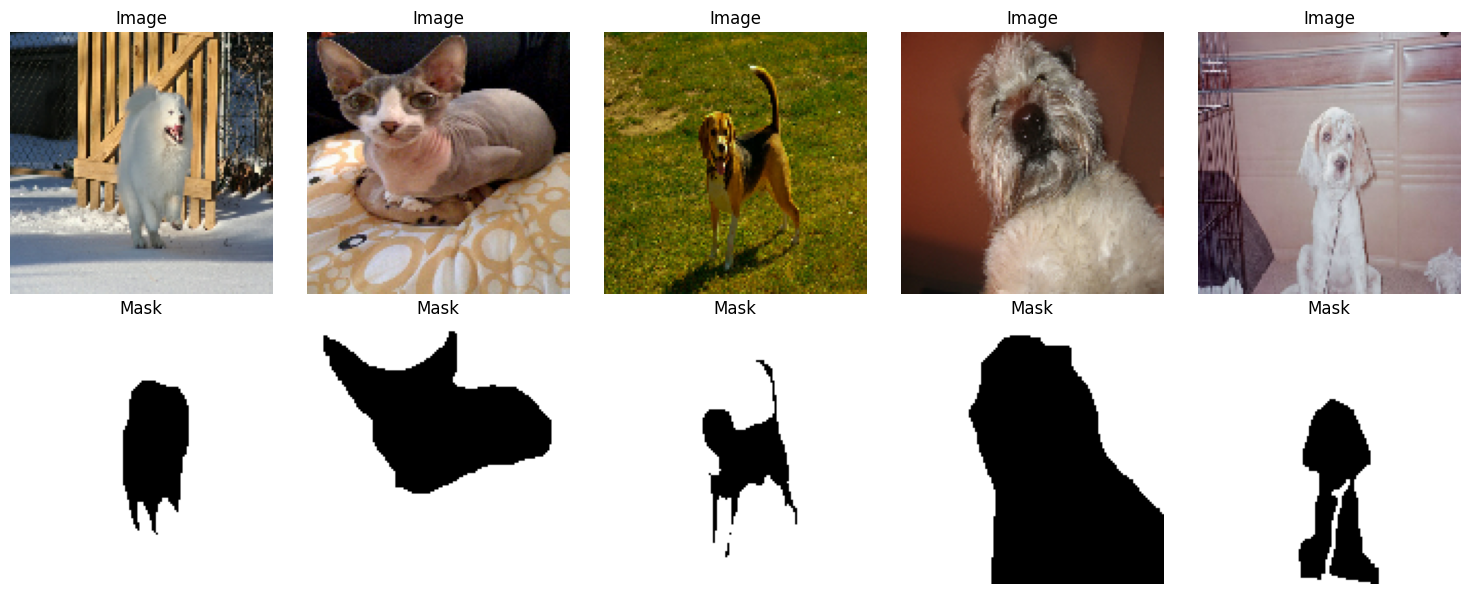

In [9]:
def load_image_and_mask(image_path, mask_path):
    """Load and preprocess an image-mask pair."""
    # Image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE) / 255.0  # Normalize to [0, 1]

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method="nearest")
    mask = tf.where(mask > 1, 1, 0)  # Binary: 0 = background, 1 = pet

    return image, mask

def display_sample(dataset):
    """Show a sample of 5 image-mask pairs from the dataset."""
    for images, masks in dataset.take(1):
        fig, ax = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
            ax[0, i].imshow(images[i])
            ax[0, i].set_title("Image")
            ax[0, i].axis("off")
            ax[1, i].imshow(masks[i].numpy().squeeze(), cmap="gray")
            ax[1, i].set_title("Mask")
            ax[1, i].axis("off")
        plt.tight_layout()
        plt.show()

# Split into train and validation sets
def train_val_split(image_files, mask_files, val_ratio=0.2):
    """Create train and validation datasets."""
    image_train, image_val, mask_train, mask_val = train_test_split(
        image_files, mask_files, test_size=val_ratio, random_state=42, shuffle=True
    )

    train_dataset = tf.data.Dataset.from_tensor_slices((image_train, mask_train))
    train_dataset = train_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((image_val, mask_val))
    val_dataset = val_dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

# Create datasets
train_dataset, val_dataset = train_val_split(image_files, mask_files)
display_sample(train_dataset)

## U-Net Model Definition

This is our base U-Net architecture for binary segmentation.

In [10]:
def build_unet(input_shape=(128, 128, 3)):
    """Build a U-Net model with skip connections."""
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c3)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u4)
    c4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(c5)

    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c5)

    return Model(inputs, outputs)

# Build and summarize the base model
base_model = build_unet()
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Evaluation Metrics

We’ll use these metrics to evaluate model quality and performance:
- **Accuracy**: Pixel-wise correctness.
- **Dice Coefficient**: Overlap between prediction and ground truth.
- **IoU**: Intersection over Union.

In [11]:
def compute_accuracy(y_true, y_pred, threshold=0.5):
    """Calculate pixel-wise accuracy."""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.reduce_prod(tf.cast(tf.shape(y_true), tf.float32))
    return correct / total

def compute_dice(y_true, y_pred, threshold=0.5):
    """Calculate Dice coefficient."""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + K.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + K.epsilon())

def compute_iou(y_true, y_pred, threshold=0.5):
    """Calculate Intersection over Union (IoU)."""
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

## Benchmarking Functions

These functions measure model size, inference time, memory usage, and quality metrics.

In [12]:
def benchmark_keras_model(model, val_dataset, num_samples=100):
    """Benchmark a Keras model on performance and quality."""
    # Model size
    model_path = "unet_model.keras"
    model.save(model_path)
    model_size = os.path.getsize(model_path) / (1024 * 1024)  # MB

    # Prepare test data
    test_images, test_masks = [], []
    for img, mask in val_dataset.take(num_samples // BATCH_SIZE):
        test_images.append(img.numpy())
        test_masks.append(mask.numpy())
    test_images = np.vstack(test_images)
    test_masks = np.vstack(test_masks)

    # Benchmark
    inference_times, accuracies, dices, ious = [], [], [], []
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 * 1024)  # MB

    for i in range(num_samples):
        input_data = test_images[i:i+1]
        start_time = time.time()
        output = model.predict(input_data, verbose=0)
        inference_times.append(time.time() - start_time)

        accuracies.append(compute_accuracy(test_masks[i], output))
        dices.append(compute_dice(test_masks[i], output))
        ious.append(compute_iou(test_masks[i], output))

    mem_after = process.memory_info().rss / (1024 * 1024)
    return {
        "model_size_mb": model_size,
        "avg_inference_time_ms": np.mean(inference_times) * 1000,
        "memory_usage_mb": mem_after - mem_before,
        "avg_accuracy": np.mean(accuracies),
        "avg_dice": np.mean(dices),
        "avg_iou": np.mean(ious)
    }

def benchmark_tflite_model(tflite_path, val_dataset, num_samples=100):
    """Benchmark a TFLite model on performance and quality."""
    # Model size
    model_size = os.path.getsize(tflite_path) / (1024 * 1024)  # MB

    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare test data
    test_images, test_masks = [], []
    for img, mask in val_dataset.take(num_samples // BATCH_SIZE):
        test_images.append(img.numpy())
        test_masks.append(mask.numpy())
    test_images = np.vstack(test_images)
    test_masks = np.vstack(test_masks)

    # Benchmark
    inference_times, accuracies, dices, ious = [], [], [], []
    process = psutil.Process()
    mem_before = process.memory_info().rss / (1024 * 1024)  # MB

    for i in range(num_samples):
        input_data = test_images[i:i+1].astype(np.float32)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        start_time = time.time()
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]["index"])
        inference_times.append(time.time() - start_time)

        accuracies.append(compute_accuracy(test_masks[i], output))
        dices.append(compute_dice(test_masks[i], output))
        ious.append(compute_iou(test_masks[i], output))

    mem_after = process.memory_info().rss / (1024 * 1024)
    return {
        "model_size_mb": model_size,
        "avg_inference_time_ms": np.mean(inference_times) * 1000,
        "memory_usage_mb": mem_after - mem_before,
        "avg_accuracy": np.mean(accuracies),
        "avg_dice": np.mean(dices),
        "avg_iou": np.mean(ious)
    }

def print_benchmark_results(model_name, results):
    """Display benchmark results in a formatted way."""
    print(f"\n=== {model_name} Benchmark Results ===")
    print(f"Model Size: {results['model_size_mb']:.2f} MB")
    print(f"Avg Inference Time: {results['avg_inference_time_ms']:.2f} ms")
    print(f"Memory Usage: {results['memory_usage_mb']:.2f} MB")
    print(f"Accuracy: {results['avg_accuracy']:.4f}")
    print(f"Dice Coefficient: {results['avg_dice']:.4f}")
    print(f"IoU: {results['avg_iou']:.4f}")
    print("=====================")

## Training the Base Model

Let’s train the original U-Net to establish a baseline.

In [13]:
# Train base model
base_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history1 = base_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# Benchmark
results_original = benchmark_keras_model(base_model, val_dataset)
print_benchmark_results("Original U-Net", results_original)

Epoch 1/5


2025-03-11 15:45:57.828412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1183/1183 [==============================] - ETA: 0s - loss: 0.4991 - accuracy: 0.7261

2025-03-11 15:46:28.748846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 35s 28ms/step - loss: 0.4991 - accuracy: 0.7261 - val_loss: 0.4698 - val_accuracy: 0.7422
Epoch 2/5
1181/1183 [============================>.] - ETA: 0s - loss: 0.4575 - accuracy: 0.7639

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 34s 29ms/step - loss: 0.4574 - accuracy: 0.7640 - val_loss: 0.4621 - val_accuracy: 0.7606
Epoch 3/5
1182/1183 [============================>.] - ETA: 0s - loss: 0.4195 - accuracy: 0.7961

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 34s 29ms/step - loss: 0.4194 - accuracy: 0.7961 - val_loss: 0.4271 - val_accuracy: 0.8025
Epoch 4/5
1181/1183 [============================>.] - ETA: 0s - loss: 0.3712 - accuracy: 0.8301

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 34s 29ms/step - loss: 0.3711 - accuracy: 0.8302 - val_loss: 0.3707 - val_accuracy: 0.8323
Epoch 5/5
1181/1183 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8514

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 34s 29ms/step - loss: 0.3340 - accuracy: 0.8515 - val_loss: 0.3914 - val_accuracy: 0.8403


2025-03-11 15:48:48.773343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Original U-Net Benchmark Results ===
Model Size: 0.51 MB
Avg Inference Time: 25.01 ms
Memory Usage: 68.70 MB
Accuracy: 0.8516
Dice Coefficient: 0.8909
IoU: 0.8135


## Optimization Techniques

### 1. Post-Training Quantization (INT8)

Convert the model to INT8 for smaller size and faster inference.

In [14]:
# Convert to TFLite with INT спря8 quantization
converter = tf.lite.TFLiteConverter.from_keras_model(base_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save
with open("unet_quant_int8.tflite", "wb") as f:
    f.write(tflite_quant_model)

# Benchmark
results_quantized_int8 = benchmark_tflite_model("unet_quant_int8.tflite", val_dataset)
print_benchmark_results("Quantized (INT8)", results_quantized_int8)

INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp7g3gnfjk/assets


INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp7g3gnfjk/assets
2025-03-11 15:49:12.177124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-11 15:49:12.177152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-11 15:49:12.177663: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp7g3gnfjk
2025-03-11 15:49:12.179022: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-11 15:49:12.179027: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp7g3gnfjk
2025-03-11 15:49:12.181973: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-03-11 15:49:12.183582: I tensorflow/cc/saved_model/load


=== Quantized (INT8) Benchmark Results ===
Model Size: 0.13 MB
Avg Inference Time: 5.20 ms
Memory Usage: -14.12 MB
Accuracy: 0.8514
Dice Coefficient: 0.8908
IoU: 0.8133


### 2. Quantization-Aware Training (QAT)

Train the model with quantization in mind for better accuracy.

In [15]:
# Apply QAT
quantize_model = tfmot.quantization.keras.quantize_model
qat_model = quantize_model(base_model)
qat_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history2 = qat_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_qat_model = converter.convert()

# Save
with open("unet_qat.tflite", "wb") as f:
    f.write(tflite_qat_model)

# Benchmark
results_qat = benchmark_tflite_model("unet_qat.tflite", val_dataset)
print_benchmark_results("Quantization-Aware Training", results_qat)

Epoch 1/5


2025-03-11 15:49:50.619895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1183/1183 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8639

2025-03-11 15:51:34.114515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 113s 94ms/step - loss: 0.3101 - accuracy: 0.8639 - val_loss: 0.3238 - val_accuracy: 0.8640
Epoch 2/5
1183/1183 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.8715

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 109s 92ms/step - loss: 0.2944 - accuracy: 0.8715 - val_loss: 0.2963 - val_accuracy: 0.8738
Epoch 3/5
1183/1183 [==============================] - ETA: 0s - loss: 0.2827 - accuracy: 0.8775

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 114s 97ms/step - loss: 0.2827 - accuracy: 0.8775 - val_loss: 0.3055 - val_accuracy: 0.8713
Epoch 4/5
1183/1183 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.8815

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 111s 94ms/step - loss: 0.2741 - accuracy: 0.8815 - val_loss: 0.2901 - val_accuracy: 0.8788
Epoch 5/5
1183/1183 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8845

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 109s 92ms/step - loss: 0.2681 - accuracy: 0.8845 - val_loss: 0.2813 - val_accuracy: 0.8817
INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp02nmo615/assets


INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp02nmo615/assets
/Users/raul/Projects/U-net/.conda/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-03-11 15:59:10.374833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-11 15:59:10.374845: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-11 15:59:10.374985: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmp02nmo615
2025-03-11 15:59:10.378561: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-11 15:59:10.378567: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/wb/7xv4jvys39x1c1wk7nw34


=== Quantization-Aware Training Benchmark Results ===
Model Size: 0.13 MB
Avg Inference Time: 2.66 ms
Memory Usage: -31.78 MB
Accuracy: 0.8874
Dice Coefficient: 0.9146
IoU: 0.8495


### 3. Pruning

Prune the model to reduce its complexity.

In [16]:
# Define pruning parameters
pruning_params = {
    "pruning_schedule": tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, begin_step=0, end_step=1000
    )
}

# Apply pruning
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)
pruned_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history3 = pruned_model.fit(train_dataset, epochs=1, callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

# Strip pruning wrappers
pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(pruned_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_pruned_model = converter.convert()

# Save
with open("unet_pruned.tflite", "wb") as f:
    f.write(tflite_pruned_model)

# Benchmark
results_pruned = benchmark_tflite_model("unet_pruned.tflite", val_dataset)
print_benchmark_results("Pruned", results_pruned)

2025-03-11 16:00:00.310141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1183/1183 [==============================] - 48s 39ms/step - loss: 0.3064 - accuracy: 0.8655
INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpf7na_h2a/assets


INFO:tensorflow:Assets written to: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpf7na_h2a/assets
2025-03-11 16:00:47.925975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-03-11 16:00:47.925990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-03-11 16:00:47.926111: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpf7na_h2a
2025-03-11 16:00:47.927178: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-03-11 16:00:47.927182: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/wb/7xv4jvys39x1c1wk7nw34qt80000gn/T/tmpf7na_h2a
2025-03-11 16:00:47.930044: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-03-11 16:00:47.951740: I tensorflow/cc/saved_model/loader.cc:215] Running initialization


=== Pruned Benchmark Results ===
Model Size: 0.13 MB
Avg Inference Time: 5.19 ms
Memory Usage: 24.47 MB
Accuracy: 0.8702
Dice Coefficient: 0.9029
IoU: 0.8309


### 4. Mixed Precision

Use mixed precision to speed up computation.

In [18]:
# Enable mixed precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Build and train
mixed_model = build_unet()
mixed_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history4 = mixed_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

# Benchmark
results_mixed = benchmark_keras_model(mixed_model, val_dataset)
print_benchmark_results("Mixed Precision", results_mixed)

Epoch 1/5


2025-03-11 16:01:21.733016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1183/1183 [==============================] - ETA: 0s - loss: 2.4381e-04 - accuracy: 0.3143

2025-03-11 16:02:02.021414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 44s 37ms/step - loss: 2.4381e-04 - accuracy: 0.3143 - val_loss: 0.0014 - val_accuracy: 0.6998
Epoch 2/5
1183/1183 [==============================] - ETA: 0s - loss: nan - accuracy: 0.7000

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 42s 35ms/step - loss: nan - accuracy: 0.7000 - val_loss: nan - val_accuracy: 0.7016
Epoch 3/5
1181/1183 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.6999

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 42s 35ms/step - loss: nan - accuracy: 0.7000 - val_loss: nan - val_accuracy: 0.7016
Epoch 4/5
1182/1183 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.6999

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 43s 37ms/step - loss: nan - accuracy: 0.7000 - val_loss: nan - val_accuracy: 0.7016
Epoch 5/5
1182/1183 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.6999

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


1183/1183 [==============================] - 43s 36ms/step - loss: nan - accuracy: 0.7000 - val_loss: nan - val_accuracy: 0.7016


2025-03-11 16:04:55.913742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Mixed Precision Benchmark Results ===
Model Size: 0.51 MB
Avg Inference Time: 27.00 ms
Memory Usage: 133.45 MB
Accuracy: 0.7187
Dice Coefficient: 0.8260
IoU: 0.7187


## Results Summary

Let’s compare all models in a nice table.

In [21]:
# Compile results
results_dict = {
    "Original": results_original,
    "Quantized (INT8)": results_quantized_int8,
    "QAT": results_qat,
    "Pruned": results_pruned,
    "Mixed Precision": results_mixed
}

# Create DataFrame
df_results = pd.DataFrame.from_dict(results_dict, orient="index").reset_index()
df_results.rename(columns={"index": "Model"}, inplace=True)

# Style the table
styled_df = df_results.style.set_table_styles([
    {"selector": "th", "props": [("text-align", "center"), ("font-weight", "bold")]},
    {"selector": "td", "props": [("text-align", "center")]}
]).format({
    "model_size_mb": "{:.2f}",
    "avg_inference_time_ms": "{:.2f}",
    "memory_usage_mb": "{:.2f}",
    "avg_accuracy": "{:.4f}",
    "avg_dice": "{:.4f}",
    "avg_iou": "{:.4f}"
}).hide(axis="index")

# Display
styled_df

Model,model_size_mb,avg_inference_time_ms,memory_usage_mb,avg_accuracy,avg_dice,avg_iou
Original,0.51,25.01,68.70,0.8516,0.8909,0.8135
Quantized (INT8),0.13,5.20,-14.12,0.8514,0.8908,0.8133
QAT,0.13,2.66,-31.78,0.8874,0.9146,0.8495
Pruned,0.13,5.19,24.47,0.8702,0.9029,0.8309
Mixed Precision,0.51,27.00,133.45,0.7187,0.8260,0.7187


## Conclusion

This notebook tested various optimization strategies on a U-Net for pet segmentation. Quantization and pruning reduced model size and inference time, while mixed precision offered a balance of speed and resource use. Adjust epochs and parameters as needed for your specific use case! Memory usage values will have to be fixed since they are currently givin negative values. I will have to look into garbage collection and the number of samples.